# CNN Cifar-10

## 1. Introduction

In [24]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import itertools
import mlflow
import mlflow.sklearn
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras.callbacks import LearningRateScheduler
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)

2.3.0


## 2. Data Preprocessing

Avant de créer un modèle ML, il est important de prétraiter les données.  
Le module suivant passe en revue les étapes de prétraitement de l'ensemble de données CIFAR10 pour nos besoins.

### 2.1 Load Data

Notre première étape consiste à charger les données et à les diviser en un ensemble de données d'entraînement et de test.  
L'ensemble de données CIFAR10 peut être téléchargé directement à partir de TensorFlow et a déjà été divisé.  
x_train est l'ensemble de données d'images couleur 32x32 d'objets sur lesquels le modèle sera entraîné.  
y_train est l'ensemble de données d'étiquettes qui correspondent à x_train.  
x_test est l'ensemble de données d'images couleur 32x32 d'objets sur lesquels le modèle sera testé.  
y_test est l'ensemble de données des étiquettes qui correspondent à x_test  

Classes:
- 0. airplane
- 1. automobile
- 2. bird
- 3. cat
- 4. deer
- 5. dog
- 6. frog
- 7. horse
- 8. ship
- 9. truck

In [3]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
image_dir = '../data/output/images'
model_dir = '../data/output/models'

In [6]:
# cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Inspection de l'ensemble du dataset

In [7]:
print('Train data shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (50000, 32, 32, 3)
Train labels shape:  (50000, 1)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)


Nous avons 50 000 images d'entraînement et 10 000 images de test dans l'ensemble de données.  
Les images ont une structure de (32,32,3) qui correspond à (largeur, hauteur, RVB).

Pour chaque image, il y a une étiquette correspondante, qui est un index de classe.

Example training images and their labels: [6, 9, 9, 4, 1]
Corresponding classes for the labels: ['frog', 'truck', 'truck', 'deer', 'automobile']


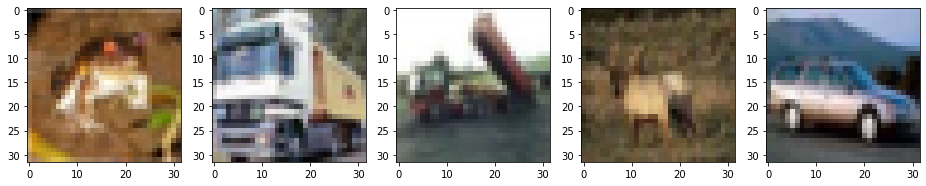

In [10]:
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print('Example training images and their labels: ' + str([x[0] for x in y_train[0:5]])) 
print('Corresponding classes for the labels: ' + str([classes[x[0]] for x in y_train[0:5]]))

f, axarr = plt.subplots(1, 5)
f.set_size_inches(16, 6)

for i in range(5):
    img = x_train[i]
    axarr[i].imshow(img)
plt.show()

In [11]:
y_train = y_train.flatten()
y_test = y_test.flatten()

In [141]:
y_test.shape

(10000,)

Le code suivant montre le nombre d'images dans chaque classe.  
On voit que chaque classe a 5000 images.  
Avoir une répartition uniforme des images est utile pour notre modèle car il aura suffisamment d'images pour en savoir plus sur les fonctionnalités de chaque classe.

C:\Users\utilisateur\anaconda3\envs\cifar\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[[Text(0, 0, 'airplane'),
  Text(1, 0, 'automobile'),
  Text(2, 0, 'bird'),
  Text(3, 0, 'cat'),
  Text(4, 0, 'deer'),
  Text(5, 0, 'dog'),
  Text(6, 0, 'frog'),
  Text(7, 0, 'horse'),
  Text(8, 0, 'ship'),
  Text(9, 0, 'truck')]]

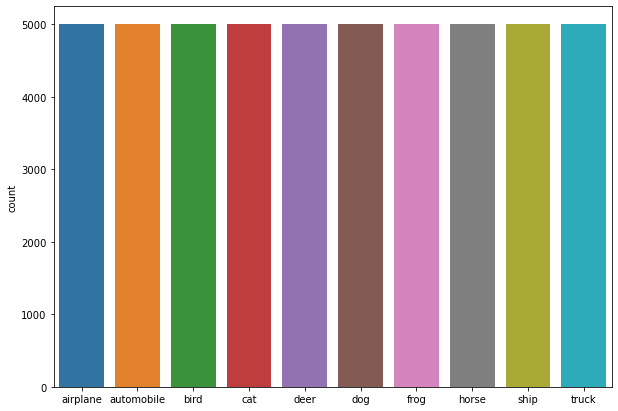

In [142]:
plt.figure(figsize=(10,7))
p = sns.countplot(y_train.flatten())
p.set(xticklabels=classes)

### 2.2 Check for NaN Values

In [12]:
np.isnan(x_train).any()

False

In [13]:
np.isnan(x_test).any()

False

Il n'y a pas de valeurs NaN dans notre dataset.  
Il n'est pas nécessaire de prétraiter les données pour traiter les NaN.

### 2.3 Normalization and Reshaping

Étant donné que les valeurs de notre dataset x_train sont des images couleur 32x32, notre forme d'entrée doit être spécifiée pour que notre modèle sache ce qui est entré.  
La première couche de convolution attend un seul 50000x32x32x3  
Les modèles fonctionnent généralement mieux sur des valeurs normalisées. La meilleure façon de normaliser les données dépend de chaque dataset. Pour le dataset CIFAR10, nous voulons que chaque valeur soit comprise entre 0,0 et 1,0. Comme toutes les valeurs se situent à l'origine dans la plage 0,0-255,0, divisez par 255,0.  
La cellule suivante définit le input_shape pour normaliser et remodeler les données.

In [14]:
input_shape = (32, 32, 3)

x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 3)
x_train=x_train / 255.0
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 3)
x_test=x_test / 255.0

### 2.4 Label Encoding

Les étiquettes de l'ensemble de données d'entraînement et de test sont actuellement catégoriques et ne sont pas continues.  
Pour inclure un ensemble de données catégorielles dans notre modèle, nos étiquettes doivent être converties en encodages one-hot.

In [15]:
y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)

In [16]:
y_train[0]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)>

### 2.5 Visualize Data

tf.Tensor([0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(10,), dtype=float32)


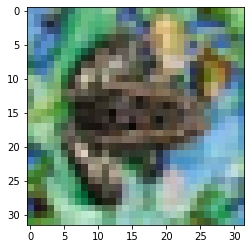

In [17]:
plt.imshow(x_train[200])
print(y_train[200])

## Metriques d'evaluation

### fonction affichant la courbe d'accuracy

In [18]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], color='red', label='Training accuracy')
    plt.plot(history.history['val_accuracy'],  color='green', label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

### fonction affichant la courbe de loss

In [19]:
def plot_loss(history):
    plt.plot(history.history['loss'], color='red', label='Training loss')
    plt.plot(history.history['val_loss'],  color='green', label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### fonction affichant la matrice de confusion

In [20]:
def confusion_matrix(model):
    # Predict the values from the validation dataset
    y_pred = model.predict(x_test)
    # Convert predictions classes to one hot vectors 
    y_pred_classes = np.argmax(y_pred,axis = 1) 
    # Convert validation observations to one hot vectors
    y_true = np.argmax(y_test,axis = 1)
    # compute the confusion matrix
    confusion_mtx = tf.math.confusion_matrix((y_true), y_pred_classes)

    plt.figure(figsize=(12, 9))
    c = sns.heatmap(confusion_mtx, annot=True, fmt='g')
    c.set(xticklabels=classes, yticklabels=classes)

## 3. CNN

In this module, we will build our CNN model.

### 3.1 Define hyperparameters

The following cell defines batch_size, num_classes, and epochs.

In [21]:
batch_size = 32
num_classes = 10
epochs = 10

### 3.2 simple CNN model

Run the following cell to build the model. The model contains various layers stacked on top of each other. The output of one layer feeds into the input of the next layer.

Conv2D layers are convolutions. Each filter (32 in the first two convolution layers and 64 in the next two convolution layers) transforms a part of the image (5x5 for the first two Conv2D layers and 3x3 for the next two Conv2D layers). The transformation is applied on the whole image.

MaxPool2D is a downsampling filter. It reduces a 2x2 matrix of the image to a single pixel with the maximum value of the 2x2 matrix. The filter aims to conserve the main features of the image while reducing the size.

Dropout is a regularization layer. In our model, 25% of the nodes in the layer are randomly ignores, allowing the network to learn different features. This prevents overfitting.

relu is the rectifier, and it is used to find nonlinearity in the data. It works by returning the input value if the input value >= 0. If the input is negative, it returns 0.

Flatten converts the tensors into a 1D vector.

The Dense layers are an artificial neural network (ANN). The last layer returns the probability that an image is in each class 
(one for each digit).

As this model aims to categorize the images, we will use a categorical_crossentropy loss function.

In [218]:
# Building up our CNN
model = Sequential()

# Convolution Layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3))) 

# Pooling with stride (2, 2)
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer 
model.add(Flatten())

# Fully connected Layer
model.add(Dense(128, activation='relu'))

# Apply Softmax
model.add(Dense(10, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# Loss function (crossentropy) and Optimizer (Adadelta)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd, 
              metrics=['accuracy'])

# Fit our model
history=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

# Evaluate our model
score = model.evaluate(x_test, y_test, verbose=1)

Epoch 1/10
1563/1563 [==============================] - 64s 41ms/step - loss: 1.4932 - accuracy: 0.4662 - val_loss: 1.3018 - val_accuracy: 0.5421
Epoch 2/10
1563/1563 [==============================] - 49s 32ms/step - loss: 1.1648 - accuracy: 0.5925 - val_loss: 1.1412 - val_accuracy: 0.6023
Epoch 3/10
1563/1563 [==============================] - 46s 30ms/step - loss: 1.0142 - accuracy: 0.6458 - val_loss: 1.0848 - val_accuracy: 0.6217
Epoch 4/10
1563/1563 [==============================] - 47s 30ms/step - loss: 0.8921 - accuracy: 0.6873 - val_loss: 1.0991 - val_accuracy: 0.6226
Epoch 5/10
1563/1563 [==============================] - 49s 31ms/step - loss: 0.7822 - accuracy: 0.7239 - val_loss: 1.1280 - val_accuracy: 0.6288
Epoch 6/10
1563/1563 [==============================] - 47s 30ms/step - loss: 0.6777 - accuracy: 0.7614 - val_loss: 1.2702 - val_accuracy: 0.6136
Epoch 7/10
1563/1563 [==============================] - 49s 31ms/step - loss: 0.5854 - accuracy: 0.7944 - val_loss: 1.2347 -

In [219]:
print(model.metrics_names)
print(score)

['loss', 'accuracy']
[1.535711407661438, 0.6236000061035156]


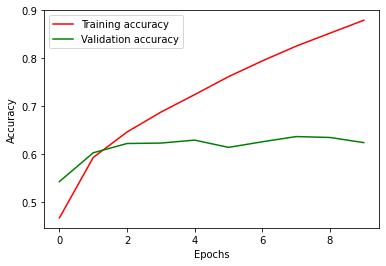

In [220]:
plot_accuracy(history)

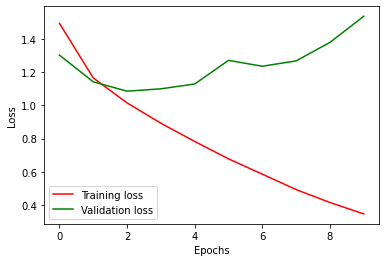

In [221]:
plot_loss(history)

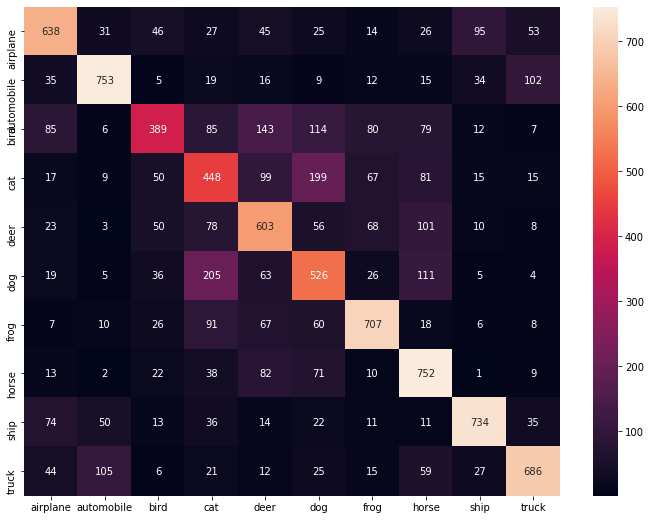

In [222]:
confusion_matrix(model)

### 3.2 Training model with Regularization

In most cases, larger models have a tendency to overfit training data.  
While getting good performance on the training set, they will perform poorly on the test set.  
Regularization methods are used to prevent overfitting, making these larger models generalize better.

#### 3.2.1 Dropout

Dropout works on a neural network layer by masking a random subset of its outputs (zeroing them) for every input with probability p and scaling up the rest of the outputs by 1/(1 - p).

Dropout is normally used during training. Masking prevents gradient backpropagation through the masked outputs. The method thus selects a random subset of the neural network to train on any particular example. This can be thought of as training a model ensemble to solve the task, with the individual models sharing parameters.

At test time, p is set to zero. This can be interpreted as averaging the outputs of the ensemble models. Because of the scaling, the expected layer outputs are the same during training and testing.

In [223]:
# Building up our CNN
model = Sequential()
# Convolution Layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3))) 
# Pooling with stride (2, 2)
model.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout layer added here
model.add(Dropout(0.25))
# Flatten layer 
model.add(Flatten())
# Fully connected Layer
model.add(Dense(128, activation='relu'))
# Dropout layer added here
model.add(Dropout(0.25))
# Apply Softmax
model.add(Dense(10, activation='softmax'))
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# Loss function (crossentropy) and Optimizer (Adadelta)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd, 
              metrics=['accuracy'])
# Fit our model
history=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
# Evaluate our model
score = model.evaluate(x_test, y_test, verbose=1)

Epoch 1/10
1563/1563 [==============================] - 54s 34ms/step - loss: 1.6200 - accuracy: 0.4161 - val_loss: 1.4110 - val_accuracy: 0.4861
Epoch 2/10
1563/1563 [==============================] - 50s 32ms/step - loss: 1.3637 - accuracy: 0.5168 - val_loss: 1.2188 - val_accuracy: 0.5669
Epoch 3/10
1563/1563 [==============================] - 51s 32ms/step - loss: 1.2501 - accuracy: 0.5561 - val_loss: 1.2298 - val_accuracy: 0.5705
Epoch 4/10
1563/1563 [==============================] - 51s 33ms/step - loss: 1.1645 - accuracy: 0.5871 - val_loss: 1.1844 - val_accuracy: 0.5818
Epoch 5/10
1563/1563 [==============================] - 52s 33ms/step - loss: 1.0929 - accuracy: 0.6134 - val_loss: 1.0823 - val_accuracy: 0.6200
Epoch 6/10
1563/1563 [==============================] - 53s 34ms/step - loss: 1.0317 - accuracy: 0.6335 - val_loss: 1.0776 - val_accuracy: 0.6227
Epoch 7/10
1563/1563 [==============================] - 52s 33ms/step - loss: 0.9838 - accuracy: 0.6523 - val_loss: 1.0872 -

In [224]:
print(model.metrics_names)
print(score)

['loss', 'accuracy']
[1.0608234405517578, 0.6395999789237976]


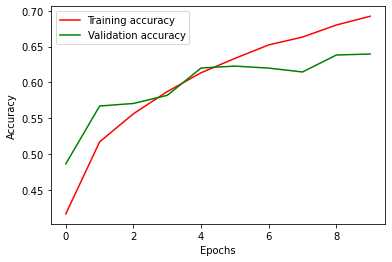

In [225]:
plot_accuracy(history)

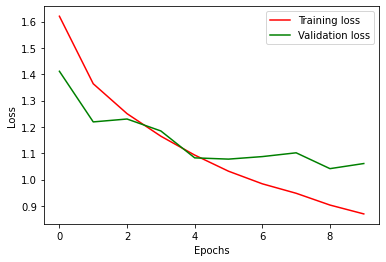

In [226]:
plot_loss(history)

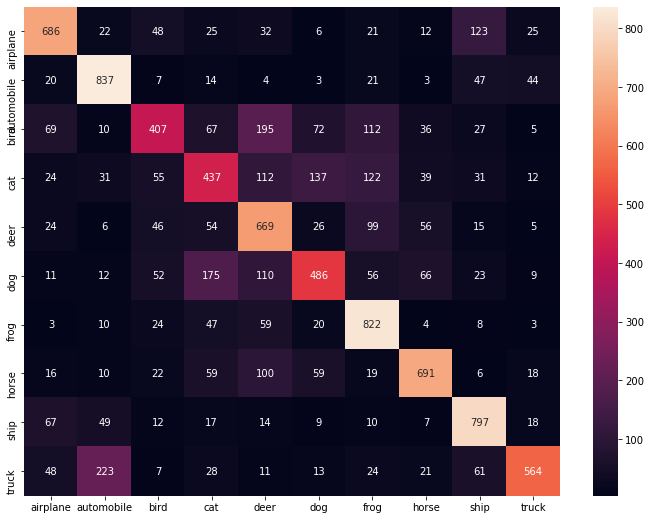

In [227]:
confusion_matrix(model)

#### 3.2.2 Batch normalization

Batch Normalization works by normalizing layer outputs to a running mean and variance.  
This speeds up training and improves the final performance of the model.  
The running statistics are fixed at test time.  
While batch normalization works as a regularizer, it also benefits smaller models.

In [198]:
# Building up our CNN
model = Sequential()
# Convolution Layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3))) 
# Batch normalization layer added here
model.add(BatchNormalization())
# Pooling with stride (2, 2)
model.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout layer added here
model.add(Dropout(0.25))
# Flatten layer 
model.add(Flatten())
# Fully connected Layer
model.add(Dense(128, activation='relu'))
# Batch normalization layer added here
model.add(BatchNormalization())
# Dropout layer added here
model.add(Dropout(0.25))
# Apply Softmax
model.add(Dense(10, activation='softmax'))
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# Loss function (crossentropy) and Optimizer (Adadelta)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd, 
              metrics=['accuracy'])
# Fit our model
history=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
# Evaluate our model
score = model.evaluate(x_test, y_test, verbose=1)

Epoch 1/10
1563/1563 [==============================] - 291s 186ms/step - loss: 1.5353 - accuracy: 0.4572 - val_loss: 1.4316 - val_accuracy: 0.4932
Epoch 2/10
1563/1563 [==============================] - 191s 122ms/step - loss: 1.2540 - accuracy: 0.5565 - val_loss: 1.1990 - val_accuracy: 0.5704
Epoch 3/10
1563/1563 [==============================] - 256s 164ms/step - loss: 1.1351 - accuracy: 0.5984 - val_loss: 1.0901 - val_accuracy: 0.6080
Epoch 4/10
1563/1563 [==============================] - 262s 167ms/step - loss: 1.0585 - accuracy: 0.6268 - val_loss: 1.4535 - val_accuracy: 0.4970
Epoch 5/10
1563/1563 [==============================] - 230s 147ms/step - loss: 1.0052 - accuracy: 0.6455 - val_loss: 1.4267 - val_accuracy: 0.5188
Epoch 6/10
1563/1563 [==============================] - 209s 134ms/step - loss: 0.9555 - accuracy: 0.6631 - val_loss: 1.1508 - val_accuracy: 0.6080
Epoch 7/10
1563/1563 [==============================] - 198s 126ms/step - loss: 0.9189 - accuracy: 0.6758 - val_

In [199]:
print(model.metrics_names)
print(score)

['loss', 'accuracy']
[0.9629395604133606, 0.6636999845504761]


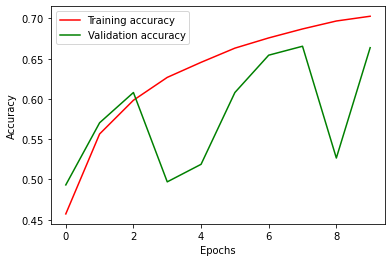

In [202]:
plot_accuracy(history)

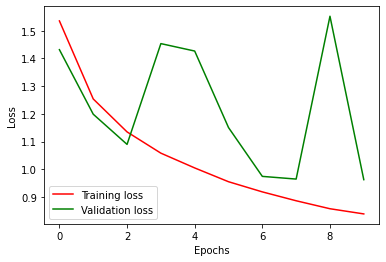

In [203]:
plot_loss(history)

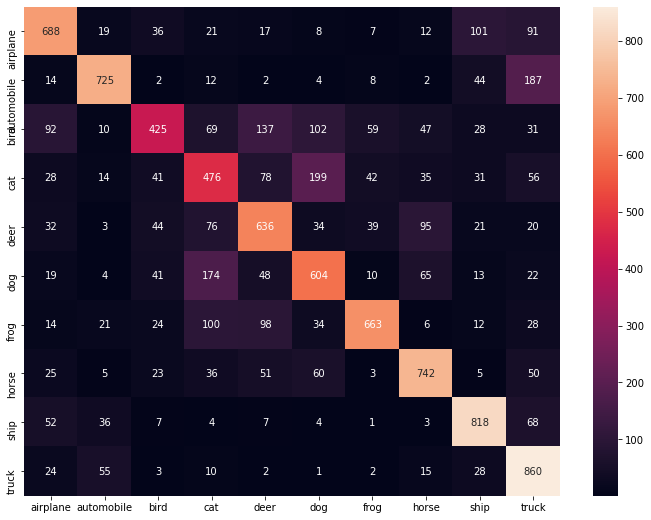

In [205]:
confusion_matrix(model)

#### 3.2.3 Data Augmentation

In [209]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True)   # flip images horizontally

validation_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(x_train[:40000], y_train[:40000], batch_size=32)
validation_generator = validation_datagen.flow(x_train[40000:], y_train[40000:], batch_size=batch_size)

In [210]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3)))
# Batch normalization layer added here
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
# Batch normalization layer added here
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

adam = Adam(lr=0.0006, beta_1=0.9, beta_2=0.999, decay=0.0)

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

In [212]:
# fits the model on batches with real-time data augmentation:
history = model.fit_generator(train_generator,    
                    validation_data=validation_generator,
                    validation_steps=len(x_train[40000:]) / 32,
                    steps_per_epoch=len(x_train[:40000]) / 32,
                    epochs=epochs,
                    verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
1250/1250 [==============================] - 317s 253ms/step - loss: 1.6458 - accuracy: 0.4225 - val_loss: 1.3351 - val_accuracy: 0.5125
Epoch 2/10
1250/1250 [==============================] - 303s 243ms/step - loss: 1.2864 - accuracy: 0.5399 - val_loss: 1.2124 - val_accuracy: 0.5788
Epoch 3/10
1250/1250 [==============================] - 275s 220ms/step - loss: 1.1928 - accuracy: 0.5771 - val_loss: 1.2072 - val_accuracy: 0.5699
Epoch 4/10
1250/1250 [==============================] - 343s 274ms/step - loss: 1.1360 - accuracy: 0.5993 - val_loss: 0.9893 - val_accuracy: 0.6400
Epoch 5/10
1250/1250 [==============================] - 326s 261ms/step - loss: 1.1046 - accuracy: 0.6101 - val_loss: 1.1145 - val_accuracy: 0.6223
Epoch 6/10
1250/1250 [==============================] - 315s 252ms/step - loss: 1.0716 - accuracy: 0.6235 - val_loss: 0.9772 - val_accuracy: 0.6574
Epoch 7/10
1250/1250 [==============

In [214]:
print(model.metrics_names)
print(score)

['loss', 'accuracy']
[0.9629395604133606, 0.6636999845504761]


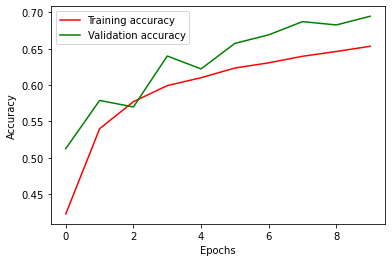

In [215]:
plot_accuracy(history)

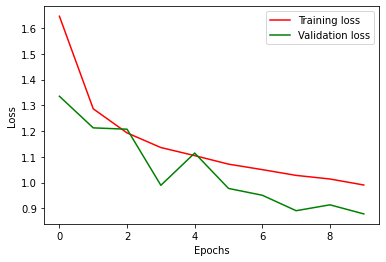

In [216]:
plot_loss(history)

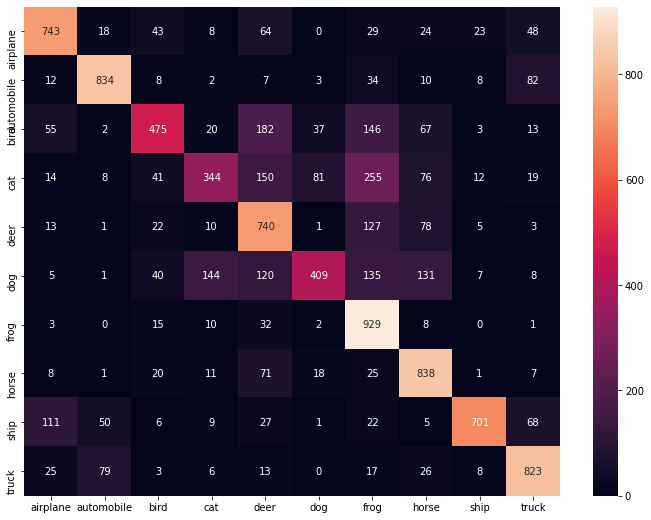

In [217]:
confusion_matrix(model)

# Another code

In [22]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

In [27]:
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
 
model.summary()
 
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)
 
#training
batch_size = 32
 
opt_rms = RMSprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=10,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_12 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)       

In [28]:
print(model.metrics_names)
print(score)

['loss', 'accuracy']


NameError: name 'score' is not defined

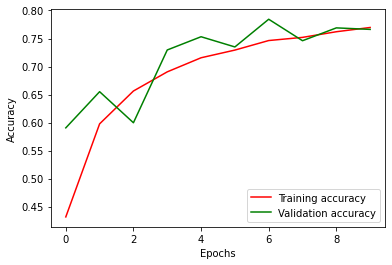

In [31]:
plot_accuracy(model.history)

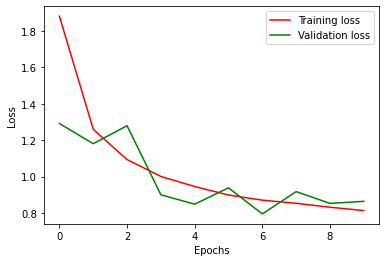

In [32]:
plot_loss(model.history)

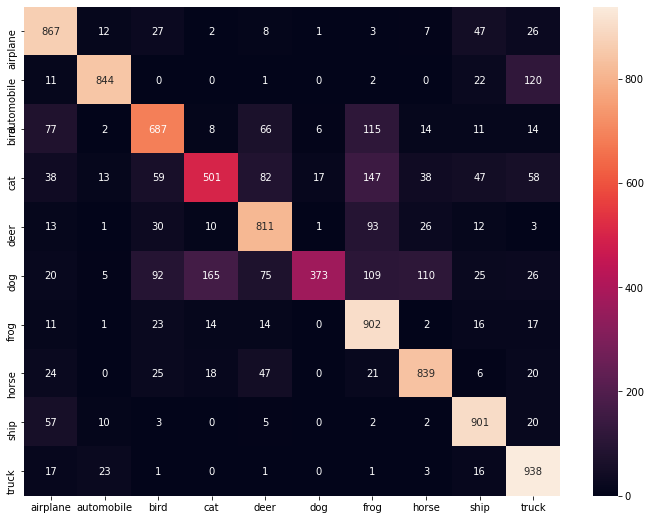

In [33]:
confusion_matrix(model)

In [35]:
print(model)